# [E10] 카메라 스티커앱 만들기 첫걸음
## 사진 불러오기 & 확인

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

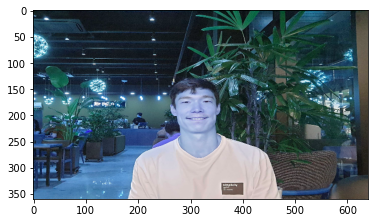

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image4.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

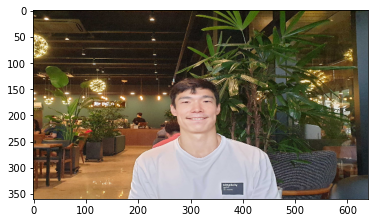

In [3]:
# 색깔 보정
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요.
# cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.
# cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
# cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Face Detection

- Histogram of Oriented Gradient feature(HOG) 사용해서 Support Vector Machine의 sliding window로 얼굴 찾음.
- gradient feature 사용하는 이유: 그냥 rgb값보다는 인접한 픽셀들 변화율을 사용하면 object 특징이 더 정확히 반영. (밝기가 변하는 방향을 고려하면 주변상황과 무관하게 detection할 수 있음.)
- [Image Pyramids](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # brg -> rgb
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(265, 146) (354, 236)]]


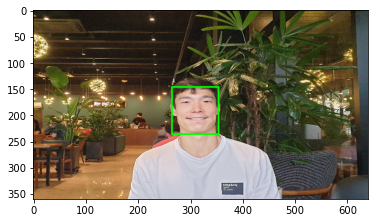

In [5]:
# upsampling을 통해 크기를 키움: Image Pyramids
# 작게 촬영된 얼굴을 더 정확하게 볼 수 있음.
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Face Landmark
Object Keypoint estimation algorithm - top-down 방식 사용
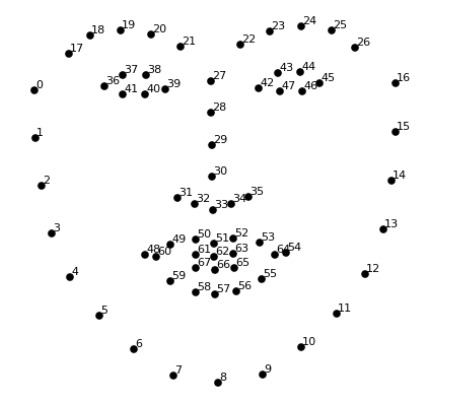
[알고리즘](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)

In [6]:
# model 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
# rectangle 입력받아 full_object_detection 반환
# (x,y) 68개의 리스트
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


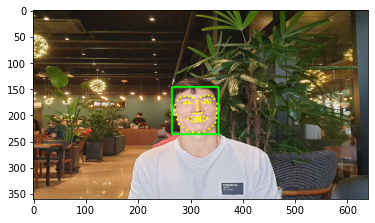

In [8]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기 (왕관)
- 여기서는 사진이 살짝 틀어졌으므로 코 정중앙이 아닌 살짝 왼쪽을 택함.

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[32]) # nose center index : 30
    x = landmark[32][0]
    y = landmark[32][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(310, 196)
(x,y) : (310,151)
(w,h) : (90,91)


In [10]:
# 왕관 스티커
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(91, 90, 3)


In [11]:
# x,y 좌표 조정
refined_x = x - w//2
refined_y = y 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (265,151)


In [12]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    print (img_sticker.shape)
    refined_y = 0
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
else:
    print (img_sticker.shape)
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(91, 90, 3)
(x,y) : (265,151)


In [13]:
sticker_area = img_show[(refined_y-img_sticker.shape[0]):refined_y, refined_x:(refined_x+img_sticker.shape[1])]

img_show[(refined_y-img_sticker.shape[0]):refined_y, refined_x:(refined_x+img_sticker.shape[1])] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

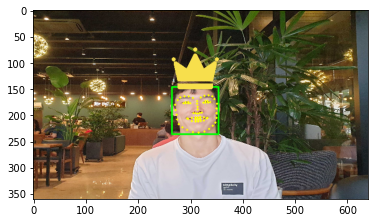

In [14]:
plt.cla()
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


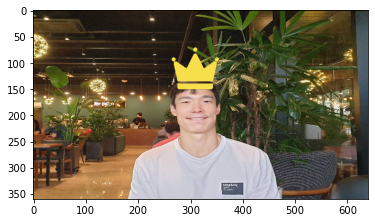

In [15]:
sticker_area = img_bgr[(refined_y-img_sticker.shape[0]):refined_y, refined_x:refined_x+img_sticker.shape[1]]

img_bgr[(refined_y-img_sticker.shape[0]):refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

#transp = cv2.addWeighted(img_sticker,0.7,img_bgr,1.0,0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 스티커 적용하기 (고양이 수염)

In [16]:
for dlib_rect2, landmark2 in zip(dlib_rects, list_landmarks):
    x2 = landmark2[2][0]
    y2 = landmark2[36][1]
    w2 = (landmark[30][0] - x2)*2
    h2 = landmark[48][1] - y2
    print ('(x,y) : (%d,%d)'%(x2,y2))
    print ('(w,h) : (%d,%d)'%(w2,h2))

(310, 212)
(x,y) : (274,177)
(w,h) : (80,29)


In [17]:
# 고양이 수염 스티커
sticker_path2 = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat2.png'
img_sticker2 = cv2.imread(sticker_path2)
img_sticker2 = cv2.resize(img_sticker2, (w2,h2))
print (img_sticker2.shape)

(29, 80, 3)


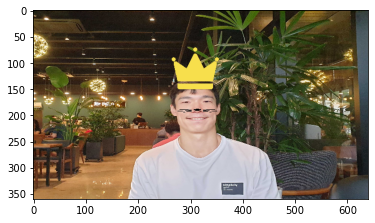

In [19]:
sticker_area2 = img_bgr[y2:y2+img_sticker2.shape[0], x2:x2+img_sticker2.shape[1]]
img_bgr[y2:y2+img_sticker2.shape[0], x2:x2+img_sticker2.shape[1]] = np.where(img_sticker2 == 255, sticker_area2, img_sticker2).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 결론

- 얼굴의 각도에 따라 스티커의 위치를 조정하기 위해 landmark도 조정해주어야 함.
- coordinate를 조정하는 것이 번거로움.
- 자동으로 좌표를 잡아주는 알고리즘을 찾아서 적용해 보아야 겠음.